In [1]:
import numpy as np
import pandas as pd 
from scipy import stats
import pickle as pkl

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mplPath

from tqdm import tqdm
from collections import Counter
import seaborn as sns

import sys
sys.path.append('../')
from basiss.preprocessing import Sample

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['figure.facecolor'] = 'white'

## Analysis of WGS and BaSISS signal 

To demonstrate that spatial BaSISS signal counts can provide a meaningful read out of the underlying somatic genotype, we first focused on three samples (ER1, ER2 and D1) from case 1. Previous multiregional WGS and targeted pulldown validation experiments identified different mixtures of at least 6 subclones across the samples 12. To enable spatial detection in serial sections of all 6 subclones, BaSISS padlock probes were designed towards 51 alleles: 25 single base substitutions and the equivalent wildtype base as well as an amplified oncogene (FGFR1).
    

<b>Fig 2A</b> Barplots of cancer cell fractions (CCF) derived from bulk-WGS of case 1.

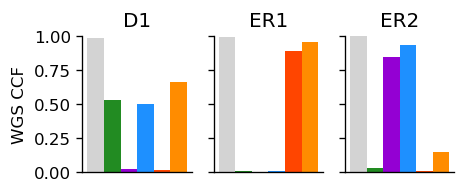

In [2]:
ccf_data = pd.read_csv('../submission/external_data/PD9694/WGS/PD9694_CCF.csv')

clone_order = [7,0,1,2,5,6]
fig, axs  = plt.subplots(1,3, figsize=(4, 1.5), sharey=True, gridspec_kw={'wspace':0.2}, dpi=120)
for i, label in enumerate(['d', 'a','c']):
    y = ccf_data.loc[clone_order, f'PD9694{label}']
    axs[i].bar(np.arange(len(y)), y, color=['lightgrey', 'forestgreen', 'darkviolet', 'dodgerblue', 'orangered', 'darkorange'],width=1)
    
    axs[i].spines['right'].set_visible(False)
    axs[i].set_title(['D1', 'ER1', 'ER2'][i])
    #axs[i].set_xlabel(f'PD9694{label}\n N = {int(n_cells/1000)}k\n purity = {round(purity*100,1)}%', labelpad=10)
    axs[i].set_xticks([])
    axs[i].set_xticklabels([])
    #axs[i].axes.get_xaxis().set_visible(False)
    axs[i].spines['top'].set_visible(False)
    #if i != 0:
    #    axs[i].axes.get_yaxis().set_visible(False)
    #    axs[i].spines['left'].set_visible(False)
    axs[i].set_ylim(0, 1)
axs[0].set_ylabel('WGS CCF');
#plt.savefig(f'../data/fields_publication_size/figures/Fig2B_barplot_WGS_CCF.pdf')

<b>Fig 2C</b> Spatial BaSISS detections for 5 selected mutations, coloured according to branch of origin. White contours indicate laser capture microdissections (LCM) subjected to WGS.


In [3]:
lcm_data = pd.read_csv('../submission/external_data/PD9694/LCM/PD9694_lcm_reads.csv')
lcm_position = pd.read_csv('../submission/external_data/PD9694/LCM/PD9694_lcm_positions.csv')

In [4]:
with open('../submission/generated_data/data_structures/data_case1_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
mut_sample_list = saved_lists['mut_sample_list']
val_sample_list = saved_lists['val_sample_list']

In [5]:
lcm_position_good = lcm_position[~pd.isna(lcm_position.spatial_rship)]
lcm_position_good['sample_index'] = [1 if x == 'PD9694a' else 2 for x in lcm_position_good.tissue_id]

/tmp/ipykernel_94277/2208455516.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcm_position_good['sample_index'] = [1 if x == 'PD9694a' else 2 for x in lcm_position_good.tissue_id]


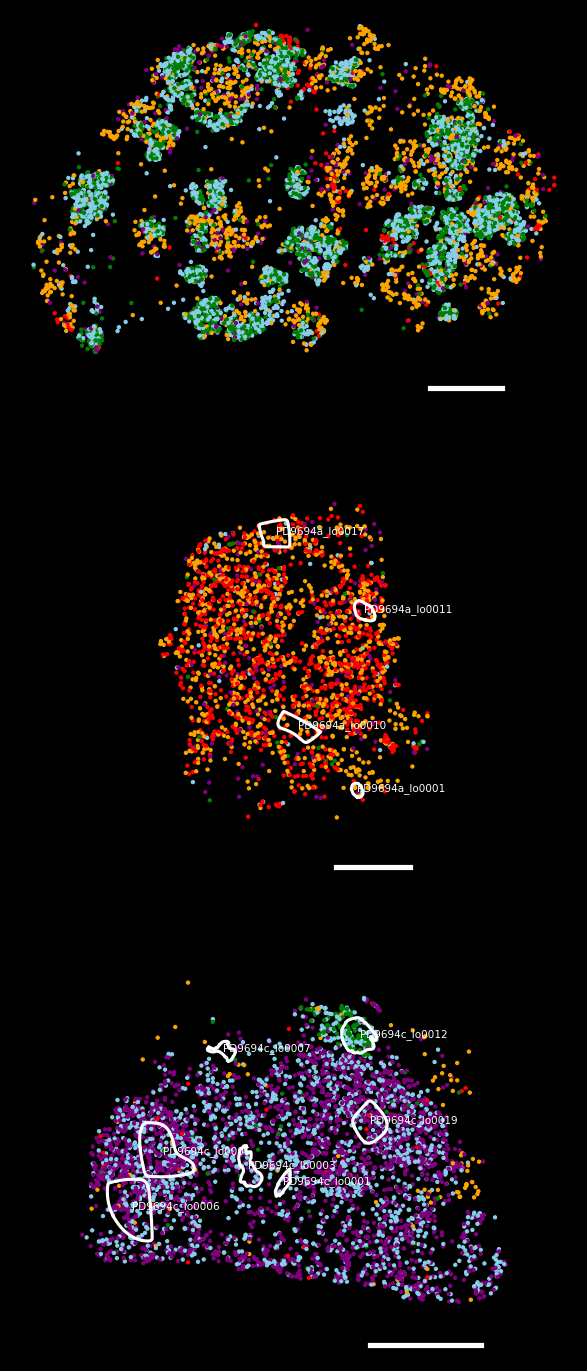

In [6]:
mut_alleles = ['CKAP5mut','DENND1Amut', 'KIAA0652mut', 'PTEN1mut', 'PTEN2mut']
wt_alleles = ['CKAP5wt', 'DENND1Awt', 'KIAA0652wt', 'PTEN1wt', 'PTEN2wt']

colors = ['skyblue', 'orange', 'green', 'purple', 'red']

fig, axs = plt.subplots(3,1,figsize=(mut_sample_list[0].spatial_dims[0]/4000*1,
                                mut_sample_list[0].spatial_dims[1]/4000*2.7), dpi=75, facecolor='black')
for s in range(3):
    df_mut = pd.DataFrame(mut_sample_list[s].data)[mut_sample_list[s].iss_probability>0.6]
    
    # with random order 
    pos_x = []
    pos_y = []
    p_color = []
    for i, allele in enumerate(mut_alleles):
        pos_x.append(df_mut.PosX[df_mut.Gene == allele])
        pos_y.append(df_mut.PosY[df_mut.Gene == allele])
        p_color.append([colors[i]]*(df_mut.Gene == allele).sum())
    pos_x = np.concatenate(pos_x)
    pos_y = np.concatenate(pos_y)
    p_color = np.concatenate(p_color)
    p_order = np.random.permutation(p_color.shape[0])
    axs[s].scatter(pos_x[p_order], pos_y[p_order], color=p_color[p_order], s=10, rasterized=True)   
    
    for i in lcm_position_good.index:
        sample_i = lcm_position_good['sample_index'][i]
        if sample_i == s:
            #print(lcm_position.WGS_sample[i])
            path_selected = mut_sample_list[sample_i].ducts['paths'][np.where(np.array(mut_sample_list[sample_i].ducts['id']) == lcm_position.histo_region[i])[0][0]]
            axs[s].text(*path_selected.mean(axis=0), lcm_position.WGS_sample[i], color='white')
            axs[s].plot(*path_selected.T, lw=3, color='white', linestyle='-')
    
    axs[s].plot([mut_sample_list[s].spatial_dims[0]*0.9,
              mut_sample_list[s].spatial_dims[0]*0.9 - 2.5e3 / 0.325 ],
             [mut_sample_list[s].spatial_dims[1]*(-0.1),
              mut_sample_list[s].spatial_dims[1]*(-0.1)], color='white', lw=5)
    
    axs[s].set_aspect('equal')
    axs[s].axis('off')
    axs[s].set_facecolor('black')
#plt.savefig(f'../data/fields_publication_size/figures/Fig2C_dotplot_mutations.pdf')


<b>Fig 2C</b> BaSISS signal detections in D2. The plots exhibit co-occurrence patterns that support proposed genotypes (see manuscript). From left ot right:
* CKAP5mut (blue clone gain), DENND1Amut (orange clone gain), KIAA0652mut (green clone gain, which is the descendent of blue)
* CKAP5wt (blue clone copy loss), DENND1Awt (orange clone copy loss), KIAA0652wt (green clone copy loss, which is descendent of blue)
* FGFR1 a gene which is highly amplified in orange clone lineage but not in blue-green



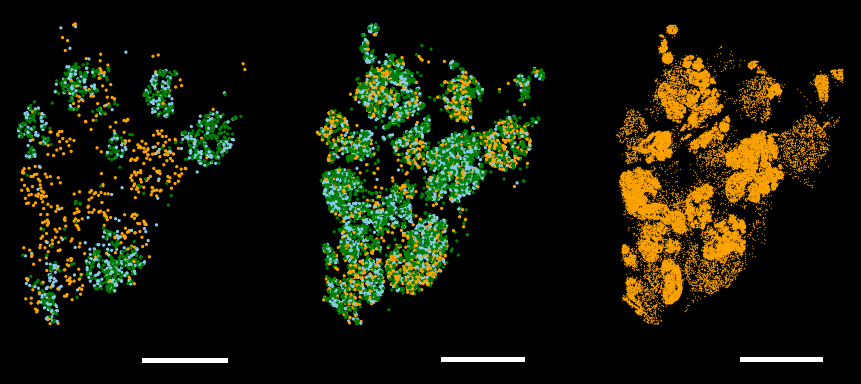

In [7]:
mut_alleles = ['CKAP5mut','DENND1Amut', 'KIAA0652mut']
wt_alleles = ['CKAP5wt', 'DENND1Awt', 'KIAA0652wt']

colors = ['skyblue', 'orange', 'green']

s=3

fig, axs = plt.subplots(1,3,figsize=(mut_sample_list[s].spatial_dims[0]/1000*2.7/4,
                                mut_sample_list[s].spatial_dims[1]/1000*2/4), facecolor='black')


df_mut = pd.DataFrame(mut_sample_list[s].data)[mut_sample_list[s].iss_probability>0.6]


pos_x = []
pos_y = []
p_color = []
for i, allele in enumerate(mut_alleles):
    pos_x.append(df_mut.PosX[df_mut.Gene == allele])
    pos_y.append(df_mut.PosY[df_mut.Gene == allele])
    p_color.append([colors[i]]*(df_mut.Gene == allele).sum())
pos_x = np.concatenate(pos_x)
pos_y = np.concatenate(pos_y)
p_color = np.concatenate(p_color)
p_order = np.random.permutation(p_color.shape[0])
axs[0].scatter(pos_x[p_order], pos_y[p_order], color=p_color[p_order], s=10/2)   

axs[0].plot([mut_sample_list[s].spatial_dims[0]*0.9,
          mut_sample_list[s].spatial_dims[0]*0.9 - 2.5e3 / 0.325 ],
         [mut_sample_list[s].spatial_dims[1]*(-0.1),
          mut_sample_list[s].spatial_dims[1]*(-0.1)], color='white', lw=10/2)

axs[0].set_aspect('equal')
axs[0].axis('off')
axs[0].set_facecolor('black')

pos_x = []
pos_y = []
p_color = []
for i, allele in enumerate(wt_alleles):
    pos_x.append(df_mut.PosX[df_mut.Gene == allele])
    pos_y.append(df_mut.PosY[df_mut.Gene == allele])
    p_color.append([colors[i]]*(df_mut.Gene == allele).sum())
pos_x = np.concatenate(pos_x)
pos_y = np.concatenate(pos_y)
p_color = np.concatenate(p_color)
p_order = np.random.permutation(p_color.shape[0])
axs[1].scatter(pos_x[p_order], pos_y[p_order], color=p_color[p_order], s=10/2)   

axs[1].plot([mut_sample_list[s].spatial_dims[0]*0.9,
          mut_sample_list[s].spatial_dims[0]*0.9 - 2.5e3 / 0.325 ],
         [mut_sample_list[s].spatial_dims[1]*(-0.1),
          mut_sample_list[s].spatial_dims[1]*(-0.1)], color='white', lw=10/2)

axs[1].set_aspect('equal')
axs[1].axis('off')
axs[1].set_facecolor('black')


axs[2].scatter(df_mut.PosX[df_mut.Gene == 'FGFR1exp'], df_mut.PosY[df_mut.Gene == 'FGFR1exp'], color='orange', s=0.1)
axs[2].plot([mut_sample_list[s].spatial_dims[0]*0.9,
          mut_sample_list[s].spatial_dims[0]*0.9 - 2.5e3 / 0.325 ],
         [mut_sample_list[s].spatial_dims[1]*(-0.1),
          mut_sample_list[s].spatial_dims[1]*(-0.1)], color='white', lw=10/2)
axs[2].set_aspect('equal')
axs[2].axis('off')
axs[2].set_facecolor('black')
#plt.savefig(f'./images/Fig2F.pdf'.format(i))
plt.show()

### Signal correlation - basiss vs lcm

<b>Fig 2F</b> Spatial co-occurrence matrix of BaSISS mutant allele signals from D1 (top) and LCM-WGS read correlations from 6 microdissected regions of D1/D2. 

The relative co-occurrence of BaSISS alleles was calculated using the M-function (Marcon, E. & Puech, F., 2010) at a 20µm radius. Randomised point types (points have a fixed location but labels are resampled) were used as a null-hypothesis and 200 samples were used for the confidence number estimation. The exact score is computed as the deviation of the observed value from the simulation mean, normalised by the spread of the confidence intervals at the α = 0.005:

$$Score=\frac{M(obs)-M(sim)_{0.5}}{0.5(M(sim)_{0.995} - M(sim)_{0.005})}$$

Inference and confidence interval estimation was performed with `dbmss` R package. For LCM allele co-occurrence a simple Pearson correlation of variant allele frequencies between regions was used. 


In [8]:
lcm_data = pd.read_csv('../submission/external_data/PD9694/LCM/PD9694_lcm_reads.csv')
lcm_position = pd.read_csv('../submission/external_data/PD9694/LCM/PD9694_lcm_positions.csv')
lcm_position = lcm_position[np.isin(lcm_position['tissue_id'], ['PD9694d', 'PD9694l'])]

fgfr_cn_df  = pd.read_csv('../submission/external_data/PD9694/LCM/PD9694_FGFR1_copynumber_status_updated.txt', sep='\t')
fgfr_cn_df['CN1_A'] = fgfr_cn_df.nMaj1_A + fgfr_cn_df.nMin1_A

leave_genes = ['DENND1A', 'FGFR1', 'LRP1B','CKAP5', 'KIAA0652']


In [9]:
np.random.seed(0)
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage


lcm_VAF = np.stack([lcm_data[lcm_position.WGS_sample[i] + '_MtAllPct'] / 100 for i in lcm_position.index]).T
fgfr_cn = np.array([fgfr_cn_df[fgfr_cn_df.samplename == lcm_position.WGS_sample[i]].CN1_A.values for i in lcm_position.index]).T
lcm_VAF = np.concatenate([lcm_VAF, fgfr_cn])

lcm_VAF = pd.DataFrame(lcm_VAF, index = list(lcm_data.Gene) + ['FGFR1'], columns=lcm_position.WGS_sample)
lcm_VAF = lcm_VAF.iloc[np.isin(lcm_VAF.index, leave_genes),:]
lcm_VAF = lcm_VAF.T
correlations = (lcm_VAF).corr() 


df = pd.read_csv('../submission/generated_data/dbmss/pd9694d_dbmss_output.csv', index_col=0)
df['val_cor'] = (df.val - df.mmean) / ((((df.mmean - df.lo) +  (df.hi - df.mmean))/2) + 1e-10)
df['mut1'] = df['mut1'].apply(lambda x: x[:-3])
df['mut2'] = df['mut2'].apply(lambda x: x[:-3])
df = df.drop_duplicates(subset=['mut1', 'mut2'])
df = df.iloc[np.isin(df['mut1'], leave_genes),:]
df = df.iloc[np.isin(df['mut2'], leave_genes),:]
df_wide = df.pivot(index='mut1', columns='mut2', values='val_cor')

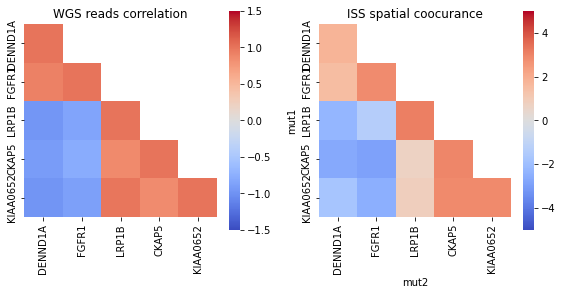

In [10]:
df1 = correlations.loc[leave_genes, leave_genes]
mask1 = np.tril(np.ones_like(df1, dtype=bool))
np.fill_diagonal(mask1, False)
df2 = df_wide.loc[leave_genes, leave_genes]
mask2 = np.triu(np.ones_like(df2, dtype=bool))
np.fill_diagonal(mask2, False)

fig, axs = plt.subplots(1,2,figsize=(8,4))
sns.heatmap(df1, mask=mask2, vmin=-1.5, vmax=1.5, cmap='coolwarm', ax=axs[0])
axs[0].set_aspect('equal')
axs[0].set_title('WGS reads correlation')
sns.heatmap(df2, mask=mask2, vmin=-5, vmax=5, cmap='coolwarm', ax=axs[1])
axs[1].set_aspect('equal')
axs[1].set_title('ISS spatial coocurance')
plt.tight_layout()

### LCM validation of model output
<b>Fig 2G</b> Heatmaps of variant allele fractions (VAFs) from 11 regions sampled in ER1 and ER2 (see Fig 2C): raw BaSISS VAFs (mutant/ mutant plus wildtype signals) (left), model imputed BaSISS VAFs (middle) and LCM-WGS derived VAFs that validate the model (right) (mean per-gene correlations are ~0.41 and ~0.90 for BaSISS to LCM-WGS and model imputed VAFs to LCM-WGS comparisons). Sample names are coloured according to the dominant BaSISS subclone in the sampled region.

The BaSISS model implicitly adjusts the observed allele frequencies for a range of systematic biases (left), stemming from the use of RNA derived signals, differential BaSISS probe sensitivity and allele confusion in order to produce highly consistent maps across replicates (middle, supported by LCM validation - right).

In [11]:
from basiss.histology import Histogenomic_associations
with open('../submission/generated_data/histogenomics/hgas.pkl', 'rb') as f:
    hgas = pkl.load(f)

In [12]:
tree = pd.read_csv('../data/PD9694_tree.csv', index_col=0)

iss_VAF = []
imputed_VAF = []

for i in tqdm(lcm_position_good.index):
    sample_i = lcm_position_good['sample_index'][i]
    region_i = lcm_position_good['histo_region'][i]

    path_selected = mut_sample_list[sample_i].ducts['paths'][np.where(np.array(mut_sample_list[sample_i].ducts['id']) == lcm_position_good.histo_region[i])[0][0]]
    bassis = mut_sample_list[sample_i].data
    xg1, yg1 = bassis['PosX'] , bassis['PosY']
    dots_within_paths = {}
    poly_area = []
    path_matplot = mplPath.Path(path_selected)
    dots_within = path_matplot.contains_points(np.array([xg1, yg1]).T)
    counts = Counter(bassis['Gene'][dots_within])

    imputed_copies = hgas[sample_i].composition_dict[region_i].mean(0)[None,:] @ tree

    iss_VAF_path = []
    loc_imputed_VAF = []
    for gene_name in lcm_data.Locus_name: 
        try:
            val_iss = counts[gene_name + 'mut'] / (counts[gene_name + 'mut'] + counts[gene_name + 'wt'])
        except ZeroDivisionError:
            val_iss = np.nan
        
        try:
            val_imp = (imputed_copies[gene_name + 'mut'] / (imputed_copies[gene_name + 'mut'] + imputed_copies[gene_name + 'wt'])).values[0]
        except KeyError:
            val_imp = np.nan
        iss_VAF_path.append(val_iss)
        loc_imputed_VAF.append(val_imp)
        
    iss_VAF.append(iss_VAF_path)
    imputed_VAF.append(loc_imputed_VAF)
    
iss_VAF = pd.DataFrame(np.array(iss_VAF), index=lcm_position_good.histo_region, columns=lcm_data.Locus_name)
imputed_VAF = pd.DataFrame(np.array(imputed_VAF), index=lcm_position_good.histo_region, columns=lcm_data.Locus_name)
lcm_VAF = np.stack([lcm_data[lcm_position_good.WGS_sample[i] + '_MtAllPct'] / 100 for i in lcm_position_good.index]).T
lcm_VAF = pd.DataFrame(lcm_VAF, index = lcm_data.Locus_name, columns=lcm_position_good.WGS_sample)

100%|██████████| 11/11 [01:00<00:00,  5.47s/it]


In [13]:
np.random.seed(0)
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage

correlations = (lcm_VAF + np.random.randn(*lcm_VAF.shape)/1000).corr() 
correlations_array = np.asarray(correlations)

col_linkage = linkage(
    distance.pdist(correlations_array), method='single')

correlations = (lcm_VAF + np.random.randn(*lcm_VAF.shape)/1000).T.corr() 
correlations_array = np.asarray(correlations)

row_linkage = linkage(
    distance.pdist(correlations_array), method='single')

col_order = dendrogram(col_linkage,
            orientation='top',
            labels=lcm_VAF.columns,
            distance_sort='descending', no_plot=True)['leaves']

row_order = dendrogram(row_linkage,
            orientation='top',
            labels=lcm_VAF.index,
            distance_sort='descending', no_plot=True)['leaves']

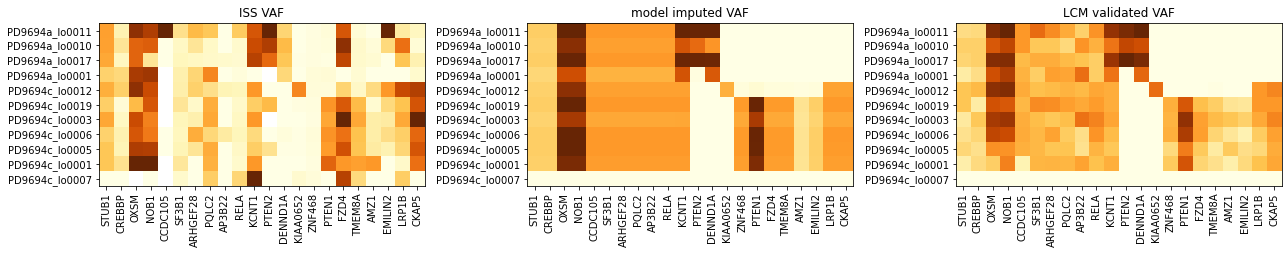

In [14]:
cmap = 'YlOrBr'
plt.rcParams['figure.facecolor'] = 'w'

genes_to_drop = ['PLXNA2', 'KIF14', 'DSEL']

dats = {}
plt.figure(figsize=(18,12))
plt.subplot(1,3,3)
dat = lcm_VAF.iloc[row_order].iloc[:,col_order].T
dat = dat.iloc[:, ~np.isin(dat.columns, genes_to_drop)]
dats['lcm'] = dat
plt.imshow(dat, cmap=cmap, vmax=1)
plt.xticks(np.arange(len(dat.columns)), dat.columns, rotation=90);
plt.yticks(np.arange(len(dat.index)), dat.index);
plt.title('LCM validated VAF')

plt.subplot(1,3,1)
iss_VAF.index = lcm_position_good.WGS_sample
dat = iss_VAF.T.iloc[row_order].iloc[:,col_order].T
dat = dat.iloc[:, ~np.isin(dat.columns, genes_to_drop)]
dats['iss'] = dat
plt.imshow(dat, cmap=cmap, vmax=1)
plt.xticks(np.arange(len(dat.columns)), dat.columns, rotation=90);
plt.yticks(np.arange(len(dat.index)), dat.index);
plt.title('ISS VAF')

plt.subplot(1,3,2)
imputed_VAF.index = lcm_position_good.WGS_sample
dat = imputed_VAF.T.iloc[row_order].iloc[:,col_order].T
dat = dat.iloc[:, ~np.isin(dat.columns, genes_to_drop)]
dats['model'] = dat
plt.imshow(dat, cmap=cmap, vmax=1)
plt.xticks(np.arange(len(dat.columns)), dat.columns, rotation=90);
plt.yticks(np.arange(len(dat.index)), dat.index);
plt.title('model imputed VAF')

plt.tight_layout()
plt.savefig(f'../figures/Fig2G_LCM_validation_heatmaps.pdf')

In [15]:
res = np.array([(np.corrcoef(dats['iss'].T.fillna(0.5).iloc[i], dats['lcm'].T.iloc[i])[1,0],
                 np.corrcoef(dats['model'].T.fillna(0.5).iloc[i], dats['lcm'].T.iloc[i])[1,0]) for i in range(dats['lcm'].T.shape[0])])

print('mean per gene correlation')
print('iss-lcm =', res.mean(0)[0])
print('model-lcm =', res.mean(0)[1])

mean per gene correlation
iss-lcm = 0.4146401680246962
model-lcm = 0.8994374080745066


<b>Fig 3B</b> Comparison of the cancer cell fractions of 9 regions of D1/D2 determined through both BaSISS (top) and LCM WGS (bottom). This is an alternative way to check model prediciont, without the signal imputation

In [16]:
lcm_ccf = pd.read_csv('../submission/external_data/PD9694/LCM/PD9694_cluster_centers.txt', sep='\t').dropna()
lcm_ccf.index = lcm_ccf['manuscript_cluster']

lcm_data = pd.read_csv('../submission/external_data/PD9694/LCM/PD9694_lcm_reads.csv')
lcm_position = pd.read_csv('../submission/external_data/PD9694/LCM/PD9694_lcm_positions.csv')
lcm_position_good = lcm_position[~pd.isna(lcm_position.spatial_rship)]
lcm_position_good['sample_index'] = [1 if x == 'PD9694a' else 2 for x in lcm_position_good.tissue_id]

clones2clusters = {0: [0,1,2,3,4,5],
                     1: [1],
                     2: [2],
                     3: [1,2,3],
                     4: [4],
                     5: [4, 5],
                     6: [6]}

/tmp/ipykernel_94277/2207182017.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lcm_position_good['sample_index'] = [1 if x == 'PD9694a' else 2 for x in lcm_position_good.tissue_id]


In [17]:
predicted_ccf = []
for i in tqdm(lcm_position_good.index):
    sample_i = lcm_position_good['sample_index'][i]
    region_i = lcm_position_good['histo_region'][i]
    
    clones_weights = hgas[sample_i].composition_dict[region_i].mean(0)[:-1]
    clones_weights = clones_weights / clones_weights.sum()
    clones_weights = clones_weights
    #print(clones_weights)
    ccf_weights = np.zeros(clones_weights.shape[0])
    for j in range(clones_weights.shape[0]):
        ccf_weights[j] += clones_weights[clones2clusters[j]].sum()
    predicted_ccf.append(ccf_weights)
    
predicted_CCF = pd.DataFrame(np.stack(predicted_ccf), index=lcm_position_good.WGS_sample, columns=['c1', 'c3', 'c5', 'c2', 'c6', 'c4'])

100%|██████████| 11/11 [00:00<00:00, 2809.65it/s]


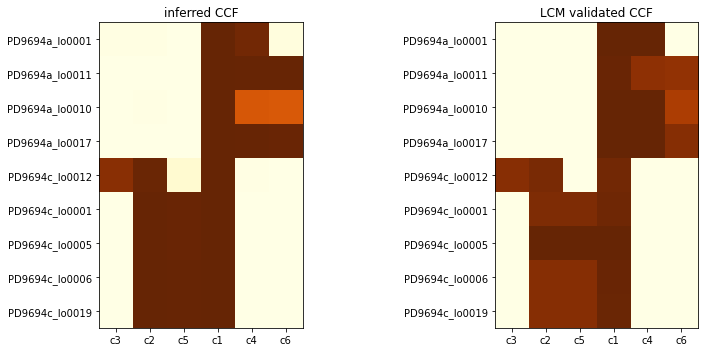

In [18]:
lcm_region_order = [f'PD9694{s}_lo' + '{:04n}'.format(x) for s, x in zip(['a'] * 4 + ['c'] * 5, [1, 11, 10, 17, 12, 1, 5, 6, 19])]
cluster_order = ['c3', 'c2', 'c5', 'c1', 'c4', 'c6']

cmap = 'YlOrBr'
plt.rcParams['figure.facecolor'] = 'w'

genes_to_drop = ['PLXNA2', 'KIF14', 'DSEL']
#sbcl_mut = ['KIAA0652',
#            'DENND1A',
#            'PTEN1', 
#            'PTEN2', 
#            'CKAP5',
#            'TMEM8A',
#            'LRP1B',
#            'FZD4',
#            'AMZ1',
#            'EMILIM2']

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
dat = predicted_CCF.loc[lcm_region_order,cluster_order]
plt.imshow(dat, cmap=cmap, vmax=1)
plt.xticks(np.arange(len(dat.columns)), dat.columns);
plt.yticks(np.arange(len(dat.index)), dat.index);
plt.title('inferred CCF')

plt.subplot(1,2,2)
dat = lcm_ccf.loc[cluster_order, lcm_region_order].T
plt.imshow(dat, cmap=cmap, vmax=1)
plt.xticks(np.arange(len(dat.columns)), dat.columns);
plt.yticks(np.arange(len(dat.index)), dat.index);
plt.title('LCM validated CCF')
plt.tight_layout()
plt.savefig(f'../figures/FigS3C_inferred_CCF_LCM_validation.pdf')

### Looking at the consistency of BaSISS and ISS signals

#### BaSISS signal

In [19]:
from basiss.preprocessing import mask_infisble
import scipy.stats as st
from itertools import combinations

In [20]:
wgs_data = pd.read_csv('../submission/external_data/PD9694/WGS/PD9694_genome_data_dec_2020.csv')
wgs_data = wgs_data[np.isin(wgs_data.ISS_id, [x[:-2] for x in mut_sample_list[0].genes])]
gene_names = wgs_data.ISS_id

scale = 3
mask = mask_infisble(mut_sample_list[:3], scale, probability=0.6, plot=False)
mask_val = mask_infisble(val_sample_list[:3], scale, probability=0.6, plot=False)

for i in range(3):
    mut_sample_list[i].data_to_grid(scale_factor=scale)
    val_sample_list[i].data_to_grid(scale_factor=scale)
    mask_infisiable = mask[i]
    mask_infisiable_val = mask_val[i]
    mut_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    val_sample_list[i].data_to_grid(scale_factor=scale, probability=0.6)
    wgs_data[f'PD9694{["d", "a", "c"][i]}_mut_counts'] = [mut_sample_list[i].gene_grid[name+'mut'].flatten()[mask_infisiable].sum() for name in gene_names]
    wgs_data[f'PD9694{["d", "a", "c"][i]}_wt_counts'] = [mut_sample_list[i].gene_grid[name+'wt'].flatten()[mask_infisiable].sum() for name in gene_names]
    wgs_data[f'PD9694{["d", "a", "c"][i]}_mut_counts_VAL'] = [val_sample_list[i].gene_grid[name+'mut'].flatten()[mask_infisiable_val].sum() for name in gene_names]
    wgs_data[f'PD9694{["d", "a", "c"][i]}_wt_counts_VAL'] = [val_sample_list[i].gene_grid[name+'wt'].flatten()[mask_infisiable_val].sum() for name in gene_names]
genes_data = wgs_data

vaf_comp = []
for s in 'dac':
    genes_data[f'depth_{s}'] = genes_data[f'DIS_sample_PD9694{s}_depth']
    genes_data[f'seqdepth_{s}'] = genes_data[f'VAL_sample_PD9694{s}_depth']
    genes_data[f'PD9694{s}_mut_reads'] = genes_data[f'DIS_MtAll_PD9694{s}']
    genes_data[f'PD9694{s}_wt_reads'] = genes_data[f'DIS_sample_PD9694{s}_depth'] - genes_data[f'DIS_MtAll_PD9694{s}']
    genes_data[f'PD9694{s}_mut_seqs'] = genes_data[f'VAL_MtAll_PD9694{s}']
    genes_data[f'PD9694{s}_wt_seqs'] = genes_data[f'VAL_sample_PD9694{s}_depth'] - genes_data[f'VAL_MtAll_PD9694{s}']
    genes_data[f'ratio_iss_{s}'] = genes_data[f'PD9694{s}_mut_counts']/(genes_data[f'PD9694{s}_mut_counts'] + genes_data[f'PD9694{s}_wt_counts'])
    genes_data[f'ratio_iss_{s}_VAL'] = genes_data[f'PD9694{s}_mut_counts_VAL']/(genes_data[f'PD9694{s}_mut_counts_VAL'] + genes_data[f'PD9694{s}_wt_counts_VAL'])
    genes_data[f'ratio_wgs_{s}'] = genes_data[f'PD9694{s}_mut_reads']/(genes_data[f'PD9694{s}_wt_reads'] + genes_data[f'PD9694{s}_mut_reads'])
    genes_data[f'ratio_dna_{s}'] = genes_data[f'PD9694{s}_mut_seqs']/(genes_data[f'PD9694{s}_wt_seqs'] + genes_data[f'PD9694{s}_mut_seqs'])
    genes_data[f'counts_{s}'] = (genes_data[f'PD9694{s}_mut_counts'] + genes_data[f'PD9694{s}_wt_counts'])
    genes_data[f'counts_{s}_VAL'] = (genes_data[f'PD9694{s}_mut_counts_VAL'] + genes_data[f'PD9694{s}_wt_counts_VAL'])
    vaf_comp.append(genes_data[['ISS_id', f'ratio_dna_{s}', f'ratio_wgs_{s}', f'ratio_iss_{s}', f'seqdepth_{s}', f'depth_{s}', f'counts_{s}', f'ratio_iss_{s}_VAL', f'counts_{s}_VAL']])
    vaf_comp[-1].columns = ['ISS_id', f'ratio_dna', f'ratio_wgs', f'ratio_iss','dna_depth', 'wgs_depth', 'iss_depth_counts', 'ratio_iss_VAL', 'iss_depth_counts_VAL']

100%|██████████| 56/56 [00:09<00:00,  5.95it/s]
/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/preprocessing/_model_data_preparation.py:27: RuntimeWarning: divide by zero encountered in true_divide
  mask_infisiable = mut_sample_list[i].gene_grid['infeasible']/t < 0.1
/nfs/research/gerstung/alomakin/projects/bassis/repo/BaSISS/notebooks/../basiss/preprocessing/_model_data_preparation.py:27: RuntimeWarning: invalid value encountered in true_divide
  mask_infisiable = mut_sample_list[i].gene_grid['infeasible']/t < 0.1
100%|██████████| 56/56 [00:03<00:00, 14.73it/s]


<b>Fig S2E</b> Scatterplots of BaSISS variant allele fractions (VAF) defined as the number of mutation specific signals divided by mutation plus wildtype signals (depth) for each mutation target between replicate BaSISS experiments (R0 and R1). Since the slices are adjacent, the cancer clone contributions should be similar, however, since barcode design was different, we expect some level of deviations

Cofidense intervals are estimated as coming from a BetaBinomial distribution with flat priors: $Beta(1+iss_{mut}, 1+iss_{wt})$

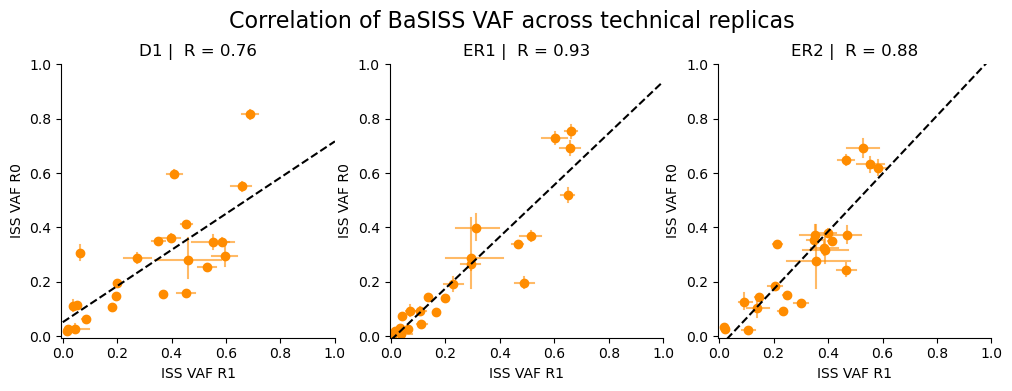

In [21]:
plt.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['pdf.fonttype'] = 42

plt.figure(figsize=(8*3/2,8/2), dpi=100)

for s in range(3):
    plt.subplot(1,3,s+1)
    coef = np.polyfit(vaf_comp[s].ratio_iss_VAL, vaf_comp[s].ratio_iss,1)
    poly1d_fn = np.poly1d(coef) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(vaf_comp[s].ratio_iss_VAL, vaf_comp[s].ratio_iss)

    plt.scatter(vaf_comp[s]['ratio_iss_VAL'], vaf_comp[s]['ratio_iss'], color='darkorange')
    
    iss_mut = vaf_comp[s].ratio_iss * vaf_comp[s].iss_depth_counts
    iss_wt = vaf_comp[s].iss_depth_counts - vaf_comp[s].ratio_iss * vaf_comp[s].iss_depth_counts
    
    iss_val_mut = vaf_comp[s].ratio_iss_VAL * vaf_comp[s].iss_depth_counts_VAL
    iss_val_wt = vaf_comp[s].iss_depth_counts_VAL - vaf_comp[s].ratio_iss_VAL * vaf_comp[s].iss_depth_counts_VAL
    
    CIs_R1 = np.array([st.beta(1+iss_mut, 1+iss_wt).ppf(0.025), st.beta(1+iss_mut, 1+iss_wt).ppf(0.975)])
    CIs_R0 = np.array([st.beta(1+iss_val_mut, 1+iss_val_wt).ppf(0.025), st.beta(1+iss_val_mut, 1+iss_val_wt).ppf(0.975)])

    plt.plot(np.array([vaf_comp[s]['ratio_iss_VAL'], vaf_comp[s]['ratio_iss_VAL']]), CIs_R1, color='darkorange', alpha=0.6, zorder=0)
    plt.plot(CIs_R0, np.array([vaf_comp[s]['ratio_iss'], vaf_comp[s]['ratio_iss']]), color='darkorange', alpha=0.6, zorder=0)
    
    plt.plot(np.linspace(0, 1, 10), poly1d_fn(np.linspace(0, 1, 10)), '--', c='black')
    plt.title(['D1', 'ER1', 'ER2'][s] + ' |  R = {}'.format(round(r_value, 2)))
    plt.xlabel('ISS VAF R1')
    plt.ylabel('ISS VAF R0')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlim(0-0.005,1)
    plt.ylim(0-0.005,1)
    plt.gca().set_aspect('equal')
plt.suptitle("Correlation of BaSISS VAF across technical replicas", fontsize=16)
plt.savefig('../figures/FigS2E_scatter_R0_R1.pdf')

<b>Fig S2F</b> Scatterplots of BaSISS VAFs (normalised to WGS VAFs) in related samples indicate that the BaSISS data provide a meaningful read out of genomic structure. Filled circle - mut, Empty circle - wt alleles, R = Pearson’s correlation coefficient.


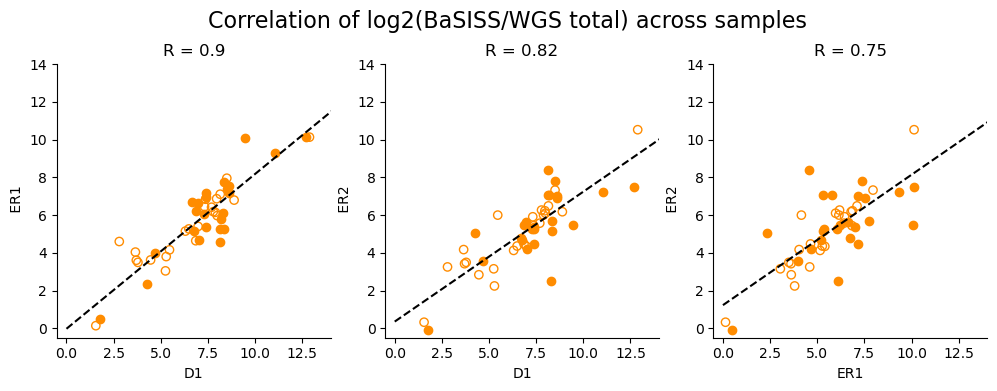

In [22]:
iss_mut = [vaf_comp[s]['ratio_iss']*vaf_comp[s]['iss_depth_counts'] for s in range(3)]
iss_wt = [vaf_comp[s]['iss_depth_counts'] - iss_mut[s] for s in range(3)]

wgs_mut = [vaf_comp[s]['ratio_wgs']*vaf_comp[s]['wgs_depth'] for s in range(3)]
wgs_wt = [vaf_comp[s]['wgs_depth'] - wgs_mut[s] for s in range(3)]

iss_combined = [np.concatenate([iss_mut[s], iss_wt[s]]) for s in range(3)]
wgs_combined = [np.concatenate([wgs_mut[s], wgs_wt[s]]) for s in range(3)]
names = np.concatenate([[i+'mut' for i in vaf_comp[0]['ISS_id']], [i+'wt' for i in vaf_comp[0]['ISS_id']]])
markers = ['darkorange']*vaf_comp[0].shape[0] + ["none"]*vaf_comp[0].shape[0]

plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(8*3/2,8/2), dpi=100)
c = 0
for s1, s2 in combinations(range(3), 2):
    plt.subplot(1,3,c+1)
    coef = np.polyfit(np.log2((iss_combined[s1]+1)/(wgs_combined[s1]+1)),
                      np.log2((iss_combined[s2]+1)/(wgs_combined[s2]+1)),1)
    poly1d_fn = np.poly1d(coef) 
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log2((iss_combined[s1]+1)/(wgs_combined[s1]+1)),
                                                                   np.log2((iss_combined[s2]+1)/(wgs_combined[s2]+1)))
    
    for i in range(len(markers)):
        plt.scatter(np.log2((iss_combined[s1][i]+1)/(wgs_combined[s1][i]+1)),
                          np.log2((iss_combined[s2][i]+1)/(wgs_combined[s2][i]+1)), color='darkorange', facecolor=markers[i])
    
    plt.plot(np.linspace(1e-3, 15, 5), poly1d_fn(np.linspace(1e-3, 15, 5)), '--', c='black')
    plt.title('R = {}'.format(round(r_value, 2)))
    plt.xlabel(f'{["D1", "ER1", "ER2"][s1]}')
    plt.ylabel(f' {["D1", "ER1", "ER2"][s2]}')
    #plt.loglog()
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlim(0-0.5,14)
    plt.ylim(0-0.5,14)
    plt.gca().set_aspect('equal')
    c +=1
plt.suptitle("Correlation of log2(BaSISS/WGS total) across samples", fontsize=16)
plt.savefig('../figures/FigS2F_scatter_ISS_by_WGS.pdf')

#### ISS imm panel
<b>Fig S1B</b> Scatterplots of between sample log2-fold change of gene expression derived from RNAseq and ISS experiments. Correlations suggest that the probes are on-target. Included genes are those with transcripts per million (TPM) >25 in RNAseq and 1000 detections per million cells in ISS whose deviation due to low counts would be neglectable (top), R = Pearson’s correlation coefficient.

(bottom) The same plot but with randomised gene RNAseq - ISS correspondense. This presents the extreme case of how the plot would look like if genes would be off target

In [23]:
### Validation of mRNA 

with open('../submission/generated_data/data_structures/data_case2_saved.pkl', 'rb') as file:
    saved_lists = pkl.load(file)
exp_sample_list_case2_expanded = np.array(saved_lists['exp_sample_list'])
imm_sample_list_case2_expanded = np.array(saved_lists['imm_sample_list'])

gene_name2good = {'PTPRC':'CD45', 'CD274':'PD-L1', 'Ki-67':'MKI67', 'Oct-4':'OCT-4', 'Oct-04': 'OCT-4'}
name2delete = ['PTPRC_trans5', 'infeasible', 'nan', 'background']
samples = ['PR14780a', 'PR14780d', 'PR14780e']

RNA_merged = pd.read_csv('../submission/external_data/RNA-bulk/merged_tpm.tsv', sep='\t')
fltr = RNA_merged[samples[0]] == 0
for i in range(1, 3):
    fltr &= RNA_merged[samples[i]] == 0
RNA_merged = RNA_merged[~fltr]
RNA_merged = RNA_merged.set_index(RNA_merged['gene'])


iss_datagrames = []
for i in range(3):
    case2 = pd.concat([pd.DataFrame(exp_sample_list_case2_expanded[i].data)[exp_sample_list_case2_expanded[i].iss_probability > 0.6],
            pd.DataFrame(imm_sample_list_case2_expanded[i].data)[imm_sample_list_case2_expanded[i].iss_probability > 0.6]]).groupby('Gene')['PosX'].count() /\
            exp_sample_list_case2_expanded[i].cellpos.shape[0] * 1e6
    #case1 = pd.concat([pd.DataFrame(exp_sample_list_case1[i].data)[exp_sample_list_case1[i].iss_probability > 0.6],
    #        pd.DataFrame(imm_sample_list_case1[i].data)[imm_sample_list_case1[i].iss_probability > 0.6]]).groupby('Gene')['PosX'].count() /\
    #        exp_sample_list_case1[i].cellpos.shape[0] * 1e6
    
    case2 = case2.drop(labels=name2delete).rename(index=gene_name2good)
    #case1 = case1.drop(labels=name2delete).rename(index=gene_name2good)

    #iss_datagrames.append(case1)
    iss_datagrames.append(case2)
    
iss_datagrames = pd.concat(iss_datagrames, axis=1)
iss_datagrames.columns = [f'{s}_ISS' for s in samples]

#iss_datagrames = iss_datagrames / iss_datagrames.sum() * 1e6

RNA_merged_aug = RNA_merged.loc[RNA_merged['gene'].isin(iss_datagrames.index)].merge(iss_datagrames, left_index=True, right_index=True)


/tmp/ipykernel_94277/4081444732.py:11: RuntimeWarning: divide by zero encountered in true_divide
  x = np.log2((RNA_merged_aug[samples_case2[s]].values) / (RNA_merged_aug[samples_case2[sj]].values))
/tmp/ipykernel_94277/4081444732.py:11: RuntimeWarning: invalid value encountered in true_divide
  x = np.log2((RNA_merged_aug[samples_case2[s]].values) / (RNA_merged_aug[samples_case2[sj]].values))
/tmp/ipykernel_94277/4081444732.py:11: RuntimeWarning: divide by zero encountered in log2
  x = np.log2((RNA_merged_aug[samples_case2[s]].values) / (RNA_merged_aug[samples_case2[sj]].values))
/tmp/ipykernel_94277/4081444732.py:11: RuntimeWarning: divide by zero encountered in log2
  x = np.log2((RNA_merged_aug[samples_case2[s]].values) / (RNA_merged_aug[samples_case2[sj]].values))
/tmp/ipykernel_94277/4081444732.py:11: RuntimeWarning: divide by zero encountered in log2
  x = np.log2((RNA_merged_aug[samples_case2[s]].values) / (RNA_merged_aug[samples_case2[sj]].values))
/tmp/ipykernel_94277/408144

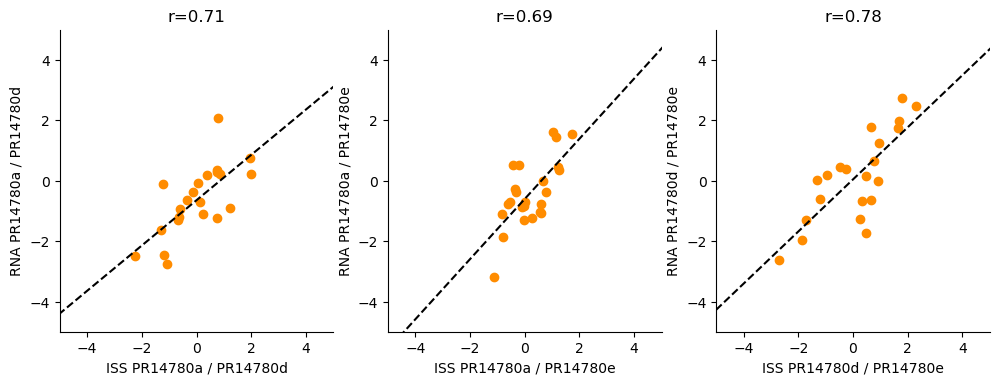

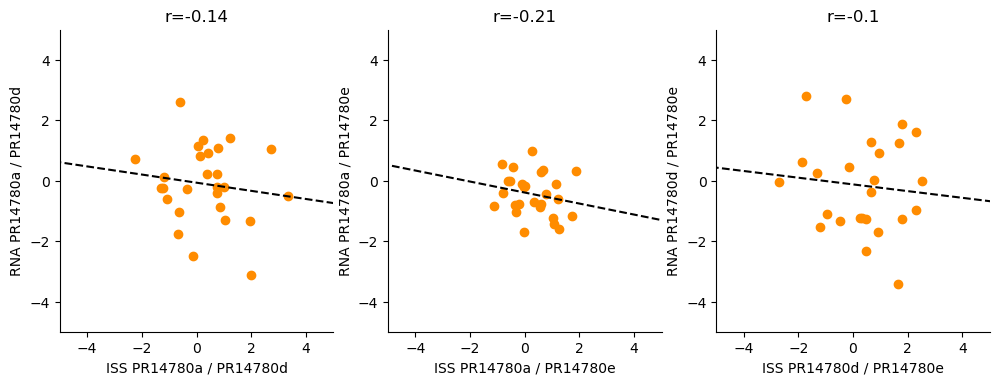

In [24]:
np.random.seed(0)

samples_case1 = ['PR9694d','PR9694a','PR9694c']
samples_case2 = ['PR14780a','PR14780d','PR14780e']

plt.figure(figsize=(8*3/2,8/2),dpi=100)
c = 0 
for s, sj in combinations(range(3), 2):
    plt.subplot(1,3,c+1)
    c+=1
    x = np.log2((RNA_merged_aug[samples_case2[s]].values) / (RNA_merged_aug[samples_case2[sj]].values))
    y = np.log2((RNA_merged_aug[f'{samples_case2[s]}_ISS'].values) / (RNA_merged_aug[f'{samples_case2[sj]}_ISS'].values))
    
    y_filt = (RNA_merged_aug[f'{samples_case2[sj]}_ISS'].values > 1000) & (RNA_merged_aug[f'{samples_case2[s]}_ISS'].values > 1000)
    x_filt = (RNA_merged_aug[f'{samples_case2[sj]}'].values > 20) & (RNA_merged_aug[f'{samples_case2[s]}'].values > 20)
    x = x[x_filt & y_filt]
    y = y[x_filt & y_filt]


    plt.scatter(x, y, color='darkorange')
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef) 
    plt.ylabel(f'RNA {samples_case2[s]} / {samples_case2[sj]}')
    plt.xlabel(f'ISS {samples_case2[s]} / {samples_case2[sj]}')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    plt.plot(np.linspace(-10, 15, 2), poly1d_fn(np.linspace(-10, 15, 2)), '--', c='black')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.title(f'r={round(r_value,2)}')
plt.savefig(f'../figures/FigS1B_PD14780_panel_validation.pdf')
    
plt.figure(figsize=(8*3/2,8/2),dpi=100)
c = 0 
for s, sj in combinations(range(3), 2):
    plt.subplot(1,3,c+1)
    c+=1
    x = np.log2((RNA_merged_aug[samples_case2[s]].values) / (RNA_merged_aug[samples_case2[sj]].values))
    y = np.log2((RNA_merged_aug[f'{samples_case2[s]}_ISS'].values) / (RNA_merged_aug[f'{samples_case2[sj]}_ISS'].values))
    y = np.random.choice(y, size=y.shape, replace=False)
    
    
    y_filt = RNA_merged_aug[f'{samples_case2[s]}_ISS'].values > 1000
    x_filt = RNA_merged_aug[f'{samples_case2[s]}'].values > 20
    x = x[x_filt & y_filt]
    y = y[x_filt & y_filt]

    plt.scatter(x, y, color='darkorange')
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef) 
    plt.ylabel(f'RNA {samples_case2[s]} / {samples_case2[sj]}')
    plt.xlabel(f'ISS {samples_case2[s]} / {samples_case2[sj]}')
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    plt.plot(np.linspace(-10, 15, 2), poly1d_fn(np.linspace(-10, 15, 2)), '--', c='black')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.title(f'r={round(r_value,2)}')